<a href="https://colab.research.google.com/github/Crossme0809/frenzyTechAI/blob/main/clip-search/Text_to_Image_And_Image_to_Image_Search_with_OpenAI_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **使用OpenAI CLIP进行文本到图像和图像到图像的搜索**

# 安装库

In [1]:
!pip install -qU transformers torch datasets gdcm pydicom pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 导入库

In [2]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

# 图像探索

## 加载数据

In [3]:
# https://huggingface.co/datasets/conceptual_captions
image_data = load_dataset(
    "conceptual_captions", split="train",
    )

Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]

Dataset conceptual_captions downloaded and prepared to /root/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8. Subsequent calls will reuse this data.


In [4]:
image_data

Dataset({
    features: ['image_url', 'caption'],
    num_rows: 3318333
})

* 我们将从这么多图像中选择300个样本（3,318,333个）

In [5]:
image_data_df = pd.DataFrame(image_data[:100])

In [6]:
image_data_df.shape

(100, 2)

In [7]:
image_data_df.head()

image_url  \
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...   
2  https://media.gettyimages.com/photos/young-con...   
3  https://thumb1.shutterstock.com/display_pic_wi...   
4  https://thumb1.shutterstock.com/display_pic_wi...   

                                             caption  
0                         a very typical bus station  
1  sierra looked stunning in this top and this sk...  
2  young confused girl standing in front of a war...  
3  interior design of modern living room with fir...  
4    cybernetic scene isolated on white background .

In [ ]:
#image_data_df.iloc[3]["caption"]

In [16]:
"""
并非所有的URL都是有效的。如果URL有效，该函数返回True；否则返回False。
"""
def check_valid_URLs(image_URL):

    try:
      response = requests.get(image_URL)
      Image.open(BytesIO(response.content))
      return True
    except:
      return False

def get_image(image_URL):
    response = requests.get(image_URL)
    image = Image.open(BytesIO(response.content))

    # 如果图像有透明度通道，则转换为RGBA格式
    if image.mode == "P" and "transparency" in image.info:
        image = image.convert("RGBA")
    else:
        image = image.convert("RGB")

    return image

def get_image_caption(image_ID):

    return image_data[image_ID]["caption"]

In [17]:
# Transform dataframe
image_data_df["is_valid"] = image_data_df["image_url"].apply(check_valid_URLs)

In [18]:
image_data_df = image_data_df[image_data_df["is_valid"]==True]
image_data_df.head()

image_url  \
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...   
2  https://media.gettyimages.com/photos/young-con...   
3  https://thumb1.shutterstock.com/display_pic_wi...   
4  https://thumb1.shutterstock.com/display_pic_wi...   

                                             caption  is_valid  
0                         a very typical bus station      True  
1  sierra looked stunning in this top and this sk...      True  
2  young confused girl standing in front of a war...      True  
3  interior design of modern living room with fir...      True  
4    cybernetic scene isolated on white background .      True

In [19]:
image_data_df.shape

(84, 3)

In [20]:
image_data_df["image"] = image_data_df["image_url"].apply(get_image)

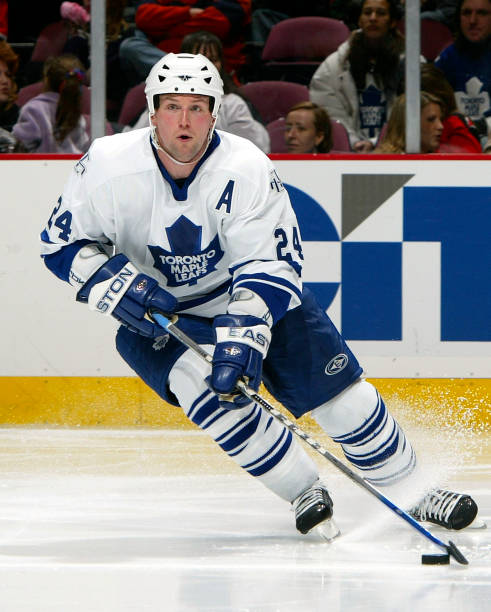

In [22]:
image_data_df.iloc[8]["image"]

In [23]:
import matplotlib.pyplot as plt

In [24]:
def get_model_info(model_ID, device):

  # 将模型保存到设备上
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # 获取处理器
  processor = CLIPProcessor.from_pretrained(model_ID)

  # 获取分词器
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # 返回模型、处理器和分词器
  return model, processor, tokenizer

In [25]:
# 设置设备
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

# 创建嵌入：文本和图像嵌入

## 文本嵌入

In [26]:
def get_single_text_embedding(text):

  inputs = tokenizer(text, return_tensors = "pt").to(device)

  text_embeddings = model.get_text_features(**inputs)

  # 将嵌入转换为NumPy数组
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

In [27]:
def get_all_text_embeddings(df, text_col):

   df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

   return df

In [28]:
image_data_df = get_all_text_embeddings(image_data_df, "caption")

In [58]:
image_data_df.head()

image_url  \
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...   
2  https://media.gettyimages.com/photos/young-con...   
3  https://thumb1.shutterstock.com/display_pic_wi...   
4  https://thumb1.shutterstock.com/display_pic_wi...   

                                             caption  is_valid  \
0                         a very typical bus station      True   
1  sierra looked stunning in this top and this sk...      True   
2  young confused girl standing in front of a war...      True   
3  interior design of modern living room with fir...      True   
4    cybernetic scene isolated on white background .      True   

                                               image  \
0  <PIL.Image.Image image mode=RGB size=800x534 a...   
1  <PIL.Image.Image image mode=RGB size=500x441 a...   
2  <PIL.Image.Image image mode=RGB size=490x612 a...   
3  <PIL.Image.Image image mode=RGB size=450x470 a...   
4  <PIL.Image.Image image mode=RGB size=450x470 a...   

                                     text_embeddings  \
0  [[0.25922322, -0.088259265, 0.020317167, -0.12...   
1  [[0.0041467287, 0.18943538, -0.12397002, 0.302...   
2  [[-0.28737974, -0.34814125, -0.042885512, 0.40...   
3  [[0.56064534, -0.15138084, -0.4374032, -0.3392...   
4  [[0.035292834, 0.24262737, -0.12724707, -0.210...   

                                      img_embeddings   cos_sim vector_id  
0  [[-0.0033994317, -0.053585485, 0.35247505, 0.3...  0.500929         0  
1  [[-0.25019792, -0.1325755, 0.097069606, 0.9788...  0.328216         1  
2  [[-0.3661711, 0.31206405, -0.13318357, 0.34914...  0.433127         2  
3  [[-0.1722096, -0.29784742, -0.101413056, -0.06...  0.468907         3  
4  [[0.18897197, -0.0012206137, -0.65132475, -0.1...  0.352396         4

## 图像嵌入

In [31]:
def get_single_image_embedding(my_image):

  image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
  )["pixel_values"].to(device)

  embedding = model.get_image_features(image)

  # 将嵌入转换为NumPy数组
  embedding_as_np = embedding.cpu().detach().numpy()

  return embedding_as_np

### 获取所有图像的嵌入

In [32]:
def get_all_images_embedding(df, img_column):

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

  return df

In [33]:
image_data_df = get_all_images_embedding(image_data_df, "image")

In [34]:
image_data_df.head()

image_url  \
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...   
2  https://media.gettyimages.com/photos/young-con...   
3  https://thumb1.shutterstock.com/display_pic_wi...   
4  https://thumb1.shutterstock.com/display_pic_wi...   

                                             caption  is_valid  \
0                         a very typical bus station      True   
1  sierra looked stunning in this top and this sk...      True   
2  young confused girl standing in front of a war...      True   
3  interior design of modern living room with fir...      True   
4    cybernetic scene isolated on white background .      True   

                                               image  \
0  <PIL.Image.Image image mode=RGB size=800x534 a...   
1  <PIL.Image.Image image mode=RGB size=500x441 a...   
2  <PIL.Image.Image image mode=RGB size=490x612 a...   
3  <PIL.Image.Image image mode=RGB size=450x470 a...   
4  <PIL.Image.Image image mode=RGB size=450x470 a...   

                                     text_embeddings  \
0  [[0.25922322, -0.088259265, 0.020317167, -0.12...   
1  [[0.0041467287, 0.18943538, -0.12397002, 0.302...   
2  [[-0.28737974, -0.34814125, -0.042885512, 0.40...   
3  [[0.56064534, -0.15138084, -0.4374032, -0.3392...   
4  [[0.035292834, 0.24262737, -0.12724707, -0.210...   

                                      img_embeddings  
0  [[-0.0033994317, -0.053585485, 0.35247505, 0.3...  
1  [[-0.25019792, -0.1325755, 0.097069606, 0.9788...  
2  [[-0.3661711, 0.31206405, -0.13318357, 0.34914...  
3  [[-0.1722096, -0.29784742, -0.101413056, -0.06...  
4  [[0.18897197, -0.0012206137, -0.65132475, -0.1...

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images):

  for image in images:
    plt.imshow(image)
    plt.show()

def plot_images_by_side(top_images):

  index_values = list(top_images.index.values)
  list_images = [top_images.iloc[idx].image for idx in index_values]
  list_captions = [top_images.iloc[idx].caption for idx in index_values]
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]

  n_row = n_col = 2

  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
      ax.imshow(img)
      sim_score = 100*float("{:.2f}".format(sim_score))
      ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
  plt.show()

# 执行相似性搜索：余弦相似度

## 1. 余弦相似度搜索

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
def get_top_N_images(query, data, top_K=4, search_criterion="text"):

    """
    检索与查询相似的前K篇文章（默认值为5）
    """
    # 文本到图像搜索
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)

    # 图像到图像搜索
    else:
      query_vect = get_single_image_embedding(query)

    # 相关列
    revevant_cols = ["caption", "image", "cos_sim"]

    # 运行相似度搜索
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))

    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])

    """
    按余弦相似度列降序排序
    在排序时从1开始，以排除与自身的相似度（因为它始终为1）
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False)[1:top_K+1]

    return most_similar_articles[revevant_cols].reset_index()

In [38]:
image_data_df.columns

Index(['image_url', 'caption', 'is_valid', 'image', 'text_embeddings',
       'img_embeddings'],
      dtype='object')

### a. 文本到图像搜索

In [39]:
query_caption = image_data_df.iloc[8].caption

top_images = get_top_N_images(query_caption, image_data_df)
print("Query: {}".format(query_caption))
top_images

Query: # of the sports team skates against sports team during their game .


index                                            caption  \
0     21  high angle view of a businessman lying on a ta...   
1     61  vector illustration of person isolated on a wh...   
2     54  a fine , grainy vector pattern in black and wh...   
3      4    cybernetic scene isolated on white background .   

                                               image   cos_sim  
0  <PIL.Image.Image image mode=RGB size=612x612 a...  0.216208  
1  <PIL.Image.Image image mode=RGB size=1500x1600...  0.211762  
2  <PIL.Image.Image image mode=RGB size=450x470 a...  0.209157  
3  <PIL.Image.Image image mode=RGB size=450x470 a...  0.208965

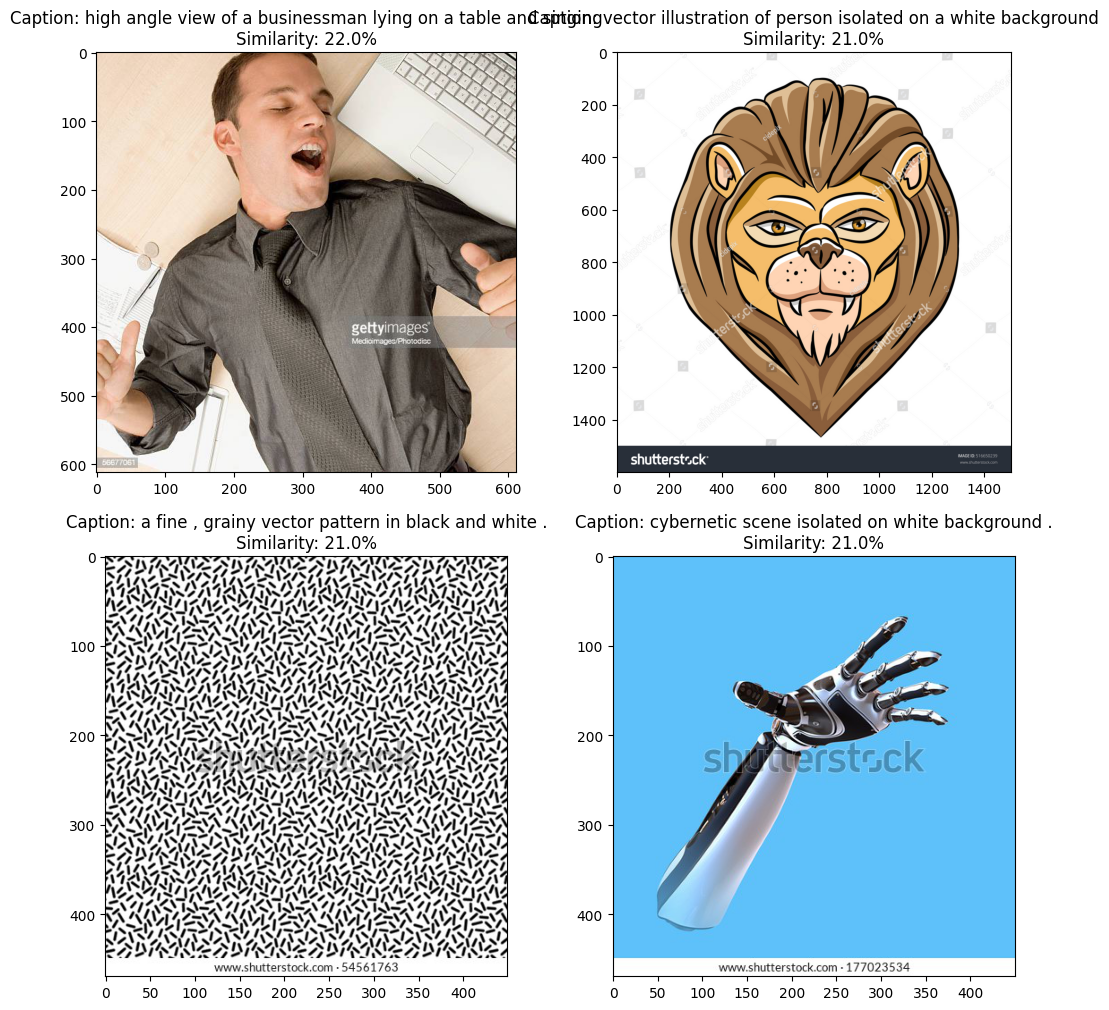

In [40]:
plot_images_by_side(top_images)

### a. 图像到图像搜索

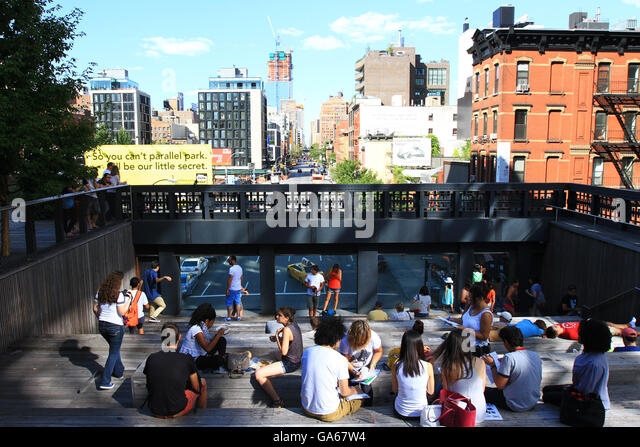

In [42]:
query_image = image_data_df.iloc[27].image
query_image

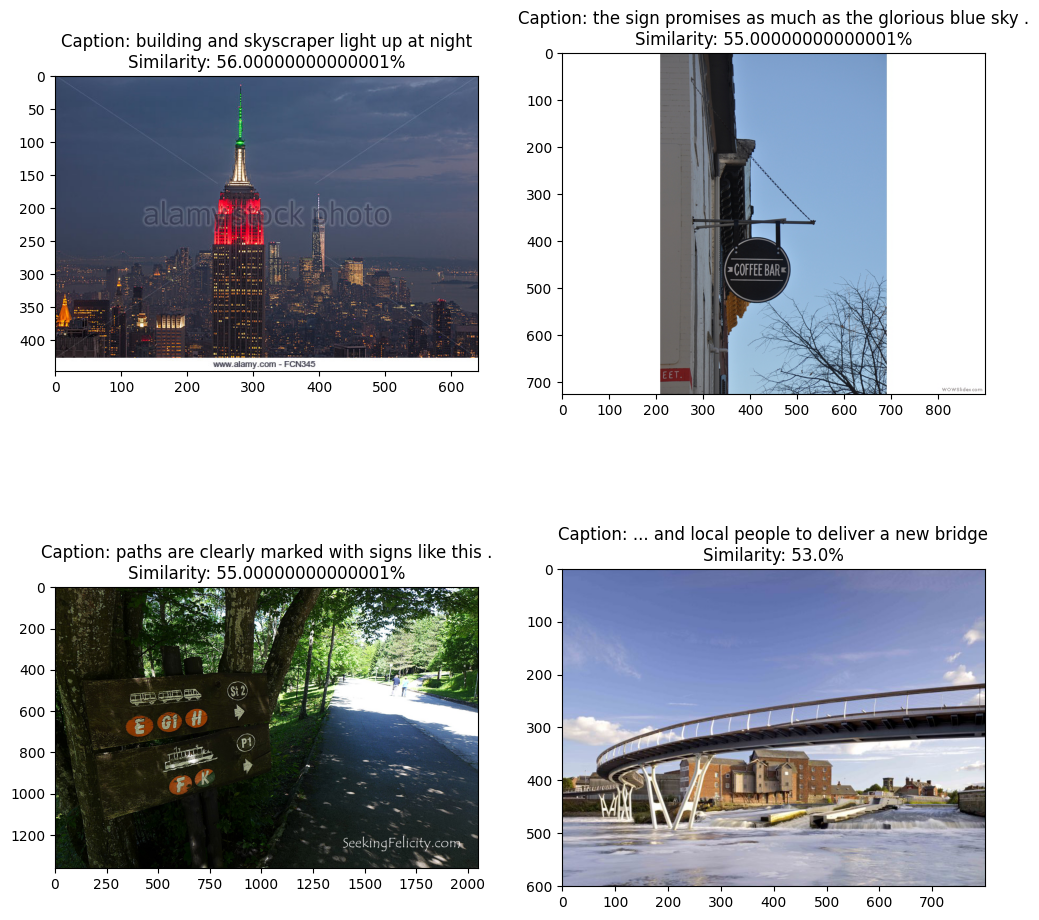

In [43]:
top_images = get_top_N_images(query_image, image_data_df, search_criterion="image")
plot_images_by_side(top_images)

## Facebook AI相似性搜索

# 方法2：Pinecone客户端库

## 配置Pinecone客户端

In [44]:
import pinecone

初始化与Pinecone的连接并创建索引。 [获取免费的API密钥](https://app.pinecone.io).

In [45]:
pinecone.init(
    api_key = "<YOUR_API_KEY>",  # app.pinecone.io
    environment="us-west1-gcp-free"
)

my_index_name = "clip-image-search"
vector_dim = image_data_df.img_embeddings[0].shape[1]

if my_index_name not in pinecone.list_indexes():
  # 创建向量维度
  pinecone.create_index(name = my_index_name,
                        dimension=vector_dim,
                        metric="cosine", shards=1,
                        pod_type='s1.x1')

# 连接到索引
my_index = pinecone.Index(index_name = my_index_name)

现在我们可以检查向量数据的状态

In [47]:
my_index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## 准备向量

In [48]:
image_data_df["vector_id"] = image_data_df.index
image_data_df["vector_id"] = image_data_df["vector_id"].apply(str)

# 获取所有元数据
final_metadata = []

for index in range(len(image_data_df)):
  final_metadata.append({
      'ID':  index,
      'caption': image_data_df.iloc[index].caption,
      'image': image_data_df.iloc[index].image_url
  })

image_IDs = image_data_df.vector_id.tolist()
image_embeddings = [arr.tolist() for arr in image_data_df.img_embeddings.tolist()]

# 创建以字典格式插入的单个列表
data_to_upsert = list(zip(image_IDs, image_embeddings, final_metadata))

# 上传最终数据
my_index.upsert(vectors = data_to_upsert)

# 检查每个命名空间的索引大小
my_index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 84}},
 'total_vector_count': 84}

# 开始查询

### 文本到图像

In [51]:
text_query = image_data_df.iloc[8].caption
text_query

'# of the sports team skates against sports team during their game .'

In [52]:
# 获取标题嵌入
query_embedding = get_single_text_embedding(text_query).tolist()

In [53]:
# 运行查询
my_index.query(query_embedding, top_k=4, include_metadata=True)

{'matches': [{'id': '8',
              'metadata': {'ID': 8.0,
                           'caption': '# of the sports team skates against '
                                      'sports team during their game .',
                           'image': 'https://media.gettyimages.com/photos/bryan-mccabe-of-the-toronto-maple-leafs-skates-against-the-new-jersey-picture-id73480619?k=6&m=73480619&s=612x612&w=0&h=99aa-OK9NQ_tJCllsuA5vifiFfxD-EW13TNYlg9m9D8='},
              'score': 0.245664299,
              'values': []},
             {'id': '21',
              'metadata': {'ID': 16.0,
                           'caption': 'high angle view of a businessman lying '
                                      'on a table and singing',
                           'image': 'https://media.gettyimages.com/photos/high-angle-view-of-a-businessman-lying-on-a-table-and-singing-picture-id56677061?s=612x612'},
              'score': 0.216207772,
              'values': []},
             {'id': '61',
            

### 图像到图像

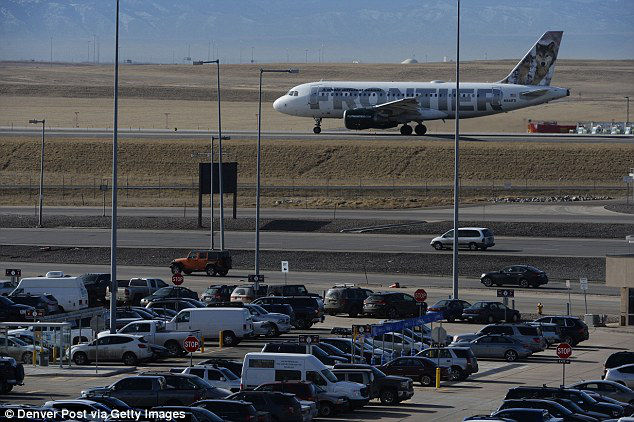

In [55]:
image_query = image_data_df.iloc[9].image
image_query

In [56]:
# 获取标题嵌入
query_embedding = get_single_image_embedding(image_query).tolist()

In [57]:
# 运行查询
my_index.query(query_embedding, top_k=4, include_metadata=True)

{'matches': [{'id': '10',
              'metadata': {'ID': 9.0,
                           'caption': 'a flight was traveling when the animal '
                                      'got free on tuesday night',
                           'image': 'http://i.dailymail.co.uk/i/pix/2016/08/10/15/371349E500000578-0-image-a-15_1470837871650.jpg'},
              'score': 0.99999994,
              'values': []},
             {'id': '62',
              'metadata': {'ID': 49.0,
                           'caption': 'emergency services were called after a '
                                      'car smashed through a set of traffic '
                                      'lights',
                           'image': 'http://www.readingchronicle.co.uk/resources/images/6179443.jpg?display=1&htype=80&type=responsive-gallery'},
              'score': 0.505660713,
              'values': []},
             {'id': '0',
              'metadata': {'ID': 0.0,
                           'caption': 'a very t

## 删除索引

完成索引后，我们可以删除它以节省资源。

In [59]:
pinecone.delete_index(my_index_name)

---